In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power
from sklearn.model_selection import train_test_split
from scipy.stats import t
import scipy.stats as stats

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

### Задание 3
**Срок сдачи: 07 апреля 18:00**

В этом задание вы будете работать с выручкой - метрикой с достаточно высокой дисперсией и соответсвенно низкой чувствительностью к изменениям.

Вам предстоит разработать подход по повышению чувствительности этой метрики.
От успеха данной инициативы зависит то, как быстро мы сможем проверять продуктовые гипотезы.

#### Для планирования эксперимента изучите данные и метрики 2 балла:

- Загрузите файл и изучите данные;
- Изучите основные статистики метрики: среднее, стандартное отклонение;
- Изучите то, как эти статистики изменяются внутри срезов: user_segment, region, category

#### Предскажите минимально детектируемый эффект (MDE) 2 балла:

- Для размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект;


#### CUPED 6 баллов
Разработайте подход по снижению дисперсии на основе методики CUPED:

- Рассчитайте CUPED метрику на основе данных за периода в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней (2 бала). 
- Проверьте насколько данный подход подвержен сезональности. Как меняется MDE, если применять данный подход в разные периоды (2 бала). 
- Оптимизируйте подход варьируя количество дней до теста, которые вы будете для расчёта CUPED метрики. Какое максимальное снижение MDE вы смогли достичь (2 бала).



#### * Стратификация 4 балла (задание для получения дополнительных баллов)
Разработайте подход по снижению дисперсии на основе методики стратификации выборок:

- Стратифицируйте выборки внутри срезов user_segment, region, category
- Рассчитайте стратифицированные среднее,стандартное отклонение для этих выборок и MDE для теста 50/50% длительностью 30 дней.
- В каких срезах достигается наибольшее снижение MDE?



#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

user_segment - сегмент пользователей

region - регион

category - категория авито

revenue_amount - сумма покупок


## EDA

In [2]:
df = pd.read_csv('user_amount_var_reduction.csv')
df['event_date']=df.event_date.apply(date_converter)

In [3]:
df.head()

,event_date,user_id,user_segment,category,region,revenue_amount
0,2019-06-18,4129257975403696,4626944681007198896,7204754148424990691,2201388710798473628,139
1,2019-06-18,7225254357470025,4626944681007198896,57514010642945023,3048517866726460689,193
2,2019-06-18,8912846500600569,4626944681007198896,5983323600580891431,3048517866726460689,160
3,2019-06-18,20910801279823046,4626944681007198896,6847326422676498281,7762196236856042106,209
4,2019-06-18,34873300821657220,2376074197230840906,3187769798308634693,3855810523611026650,160


In [4]:
df.shape

(8625842, 6)

In [8]:
df.user_segment.unique() # 3 сегмента

array([4626944681007198896, 2376074197230840906,  853431062533847667])

In [10]:
df.category.nunique() # 33 категории

33

In [11]:
df.region.nunique() # 84 региона

84

In [310]:
df.event_date.min(),df.event_date.max() # данные за 6 месяцев

(Timestamp('2019-06-18 00:00:00'), Timestamp('2019-12-09 00:00:00'))

In [409]:
df_grouped = df.groupby(['user_id', 'user_segment', 'category', 'region']).sum().reset_index()
df_grouped.head()

,user_id,user_segment,category,region,revenue_amount
0,702221222224,4626944681007198896,6742557862815872936,2201388710798473628,356
1,1336907904656,4626944681007198896,1793067034829450750,7487694187147034485,1321
2,1912219714366,4626944681007198896,3429514168013826643,1465493388238999035,1085
3,4358074930207,2376074197230840906,57514010642945023,2993565193926327180,167
4,7562887359106,4626944681007198896,5983323600580891431,4626262784213375628,139


In [415]:
def description(data, grouped_by, metric):
    
    data = data.groupby(grouped_by).sum()[metric]
    print('Mean:', np.round(data.mean(),2))
    print('Std:', np.round(data.std(),2))
    print('-------------')
    print('Min:', data.min())
    print('Max:', data.max())
    print('-------------')
    print('1%:', np.round(data.quantile(0.01),2))
    print('99%:', np.round(data.quantile(0.99),2))


Стандартное отклонение сильно выше среднего

In [416]:
description(df_grouped, 'user_id', 'revenue_amount')

Mean: 1789.88
Std: 19499.45
-------------
Min: 4.0
Max: 6630371.0
-------------
1%: 20.0
99%: 24358.0


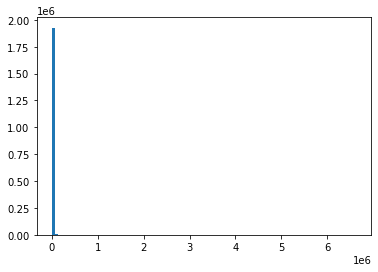

In [418]:
df_grouped_user = df_grouped.groupby('user_id').sum()
plt.hist(df_grouped_user.revenue_amount, bins = 100)
plt.show()

Очистка от выбросов 1-ым и 99-ым перцентилем немного выранивает ситуацию - стандартное отклонение сильно снижается

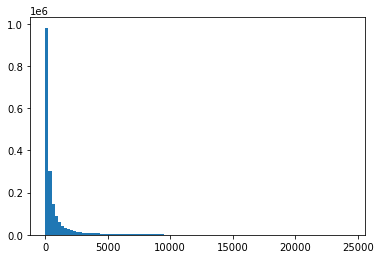

Mean: 988.4
Std: 2380.0
-------------
Min: 21.0
Max: 24357.0
-------------
1%: 21.0
99%: 13527.0


In [422]:
clean_outliers = df_grouped_user[(df_grouped_user['revenue_amount'] > df_grouped_user.revenue_amount.quantile(0.01)) &
   (df_grouped_user['revenue_amount'] < df_grouped_user.revenue_amount.quantile(0.99))]
plt.hist(clean_outliers.revenue_amount, bins=100)
plt.show()

description(clean_outliers, 'user_id', 'revenue_amount')

38к пользователей отсекается перцентилями

In [432]:
df_grouped_user.revenue_amount.shape[0], clean_outliers.shape[0], df_grouped_user.revenue_amount.shape[0] - clean_outliers.shape[0]  

(1932049, 1893253, 38796)

#### Посмотрим в разрезе категорий:

Видим, что по среднему и стандартному отклонению группы по **user_segment** достаточно сильно различаются

In [424]:
np.round(df_grouped.groupby('user_segment')['revenue_amount'].describe().sort_values('mean'),2)

,count,mean,std,min,25%,50%,75%,max
user_segment,,,,,,,,
4626944681007198896,1744488.0,429.98,1327.80,4.0,69.0,154.0,357.0,170324.0
2376074197230840906,797042.0,2022.56,7021.96,4.0,174.0,476.0,1440.0,986463.0
853431062533847667,70643.0,15514.34,71207.83,11.0,635.0,2066.0,8588.5,4938381.0


Среднее в разбивке по **category** изменяется от 247 до 27 740, стандартное отклонение - от 789 до 67 218

In [425]:
np.round(df_grouped.groupby('category')['revenue_amount'].describe().sort_values('mean'),2)

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
5387097547938806535,16915.0,247.74,789.73,8.0,48.0,97.0,208.00,24768.0
4394253463123676325,269650.0,294.11,2456.49,6.0,49.0,91.0,203.00,548380.0
7247164925237372155,96701.0,304.35,2802.72,6.0,53.0,98.0,196.00,461011.0
3619272498251215842,15759.0,383.22,1764.53,6.0,49.0,98.0,238.50,101295.0
2965866302161963961,35493.0,451.25,3779.49,6.0,52.0,112.0,259.00,402002.0
282115902545472456,22642.0,483.27,1239.70,11.0,104.0,210.0,468.00,83813.0
6864443610550051939,60939.0,484.95,4679.57,6.0,56.0,112.0,259.00,667427.0
4658595883120885993,28413.0,495.81,1708.32,8.0,70.0,161.0,392.00,119706.0
3429514168013826643,85555.0,537.87,2203.72,8.0,84.0,161.0,392.00,170324.0


По регионам размах уже не такой разительный

- Среднее - от 257 до 2320
- Стандартное отклонение - от 327 до 26 470

In [426]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(np.round(df_grouped.groupby('region')['revenue_amount'].describe().sort_values('mean'),2))
    

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
928013360687874809,164.0,257.23,327.82,13.0,81.75,160.0,323.50,2741.0
8666105090637809898,338.0,287.35,534.93,8.0,63.00,133.0,313.00,7761.0
9173615405044165275,1457.0,399.68,1172.26,6.0,62.00,150.0,328.00,25215.0
405364780634206711,532.0,401.16,1142.02,8.0,62.00,132.0,307.00,17537.0
8058405634870305347,2204.0,461.06,1245.05,8.0,70.00,160.0,329.00,18048.0
6371282152022805074,1764.0,507.44,2930.37,6.0,56.00,126.0,304.75,96783.0
1103602596183811891,3610.0,509.35,2341.38,8.0,67.00,147.0,377.00,84189.0
8443241763018219192,6767.0,512.99,1691.69,6.0,63.00,140.0,364.00,44255.0
1187552825302355021,39363.0,555.91,2472.66,6.0,63.00,140.0,347.00,227849.0


### Расчет MDE

Функция по формированию теста и контроля по дням

In [173]:
def choose_date(data, start_date, delta, share): 
    #share - размер контрольной группы
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=tmp.groupby(['user_id']).sum().reset_index()
    test, control = train_test_split(tmp, test_size=share)
    return test, control

Функция подсчета MDE в процентах прироста для уже собранного датасета по датам

In [277]:
def calc_stats_no_days(col_name, dataset, cntrl_size = 0.5):
    np.random.seed(123)
    alpha = 0.01
    power = 0.80
    
    df = dataset.shape[0]-2
    test, control = train_test_split(dataset, test_size=cntrl_size)
    
    mde = (
        t(df).ppf(1-alpha/2) 
        + 
        t(df).ppf(power) 
    ) * \
     (stats.sem(test[col_name].values) ** 2 + stats.sem(control[col_name].values) ** 2) ** 0.5
    
    mean = np.round(dataset[col_name].mean(),2)
    std = np.round(dataset[col_name].std(),2)
    
    return np.round(100*((mde+mean)/mean - 1),2), test.shape[0]

Функция подсчета MDE в процентах прироста + выделение группы по дням

In [278]:
def calc_stats(col_name, dataset, start_date, delta, cntrl_size = 0.5):
    np.random.seed(123)
    alpha = 0.01
    power = 0.80
    
    df = dataset.shape[0]-2
    test, control = choose_date(dataset, start_date, delta, cntrl_size)
    
    mde = (
        t(df).ppf(1-alpha/2) 
        + 
        t(df).ppf(power) 
    ) * \
     (stats.sem(test[col_name].values) ** 2 + stats.sem(control[col_name].values) ** 2) ** 0.5
    
    mean = np.round(dataset[col_name].mean(),2)
    std = np.round(dataset[col_name].std(),2)
    
    return np.round(100*((mde+mean)/mean - 1),2), test.shape[0]

#### Считаем MDE для разных объемов тестовых групп и длительности эксперимента

In [188]:
np.random.seed(123)
test_sizes = np.array([0.1, 0.25, 0.5])
cntrl_sizes = 1 - test_sizes
days_lasting = [30, 60, 90]
for i in days_lasting:
    print('--------------------------------------------------------------------')
    print('Количество дней - ', i)
    for j in cntrl_sizes :
        increase, tg_volume = calc_stats('revenue_amount', df, datetime.datetime(2019, 8, 18, 0, 0),i,j)
        print('Тестовая группа - ', tg_volume, '(', np.round((1-j)*100), '%)',
              'MDE роста выручки в % - ',increase)

--------------------------------------------------------------------
Количество дней -  30
Тестовая группа -  61440 ( 10.0 %) MDE роста выручки в % -  22.14
Тестовая группа -  153600 ( 25.0 %) MDE роста выручки в % -  17.98
Тестовая группа -  307200 ( 50.0 %) MDE роста выручки в % -  14.15
--------------------------------------------------------------------
Количество дней -  60
Тестовая группа -  98283 ( 10.0 %) MDE роста выручки в % -  36.82
Тестовая группа -  245709 ( 25.0 %) MDE роста выручки в % -  21.53
Тестовая группа -  491419 ( 50.0 %) MDE роста выручки в % -  18.45
--------------------------------------------------------------------
Количество дней -  90
Тестовая группа -  124586 ( 10.0 %) MDE роста выручки в % -  30.26
Тестовая группа -  311465 ( 25.0 %) MDE роста выручки в % -  22.61
Тестовая группа -  622931 ( 50.0 %) MDE роста выручки в % -  20.97


Самый маленький MDE без каких-либо дополнительных преобразований на 30 днях с 50% тестовой группой

### CUPED

Посмотрим 30 дней после 2019-8-18 и до этой даты

Функция для добавления CUPED в датасет

In [287]:
def cuped_calc(start_date, df, delta=30):
    #start_date = datetime.datetime(2019, 8, 18, 0, 0)
    #delta = 30

    print(start_date, start_date-datetime.timedelta(days=delta))

    cuped_before = df[(df.event_date<=start_date)&(df.event_date>=start_date-datetime.timedelta(days=delta))]
    cuped_before.columns = ['event_date', 'user_id', 'user_segment', 'category', 'region','revenue_before']
    cuped_before = cuped_before.groupby(['user_id', 'user_segment', 'category', 'region']).sum().reset_index()
    
    
    start_date = start_date+datetime.timedelta(1)
    #delta = 30

    print(start_date, start_date+datetime.timedelta(days=delta))

    cuped_after = df[(df.event_date>=start_date)&(df.event_date<=start_date+datetime.timedelta(days=delta))]
    cuped_after.columns = ['event_date', 'user_id', 'user_segment', 'category', 'region','revenue_after']
    cuped_after = cuped_after.groupby(['user_id', 'user_segment', 'category', 'region']).sum().reset_index()
    
    full_data = cuped_after.merge(cuped_before, how='left', on=['user_id','user_segment', 'category', 'region'])
    full_data.revenue_before = full_data.revenue_before.fillna(0).apply(int)
    
    after = full_data['revenue_after']
    before = full_data['revenue_before']

    teta = np.cov(after,before, ddof=1)[1,0]/np.var(before, ddof=1)
    full_data['cuped'] = after - (before - np.mean(before))*teta
    
    return full_data

Для 30 дней с объемом теста 50% MDE снизился аж до 1.83%

In [294]:
full_test = cuped_calc(datetime.datetime(2019, 8, 18, 0, 0), df)
test_sizes = np.array([0.5])
cntrl_sizes = 1 - test_sizes

print('Количество дней - ', 30)
for j in cntrl_sizes :
    increase, tg_volume = calc_stats_no_days('cuped', full_test,j)
    print('Тестовая группа - ', tg_volume, '(', np.round((1-j)*100), '%)',
          'MDE роста выручки в % - ',increase)

2019-08-18 00:00:00 2019-07-19 00:00:00
2019-08-19 00:00:00 2019-09-18 00:00:00
Количество дней -  30
Тестовая группа -  374843 ( 50.0 %) MDE роста выручки в % -  1.83


#### Посмотрим на других периодах - подвержена ли метрика сезональности?

In [471]:
timedeltas = np.arange(120)
MDEs = []
start_dts = []
cntrl_size = 0.5
for i in timedeltas:
    start_dt = datetime.datetime(2019, 7, 19, 0, 0) + datetime.timedelta(float(i))
    start_dts.append(start_dt)
    full_test = cuped_calc(start_dt, df)
    increase, tg_volume = calc_stats_no_days('cuped', full_test,cntrl_size)
    MDEs.append(increase)

2019-07-19 00:00:00 2019-06-19 00:00:00
2019-07-20 00:00:00 2019-08-19 00:00:00
2019-07-20 00:00:00 2019-06-20 00:00:00
2019-07-21 00:00:00 2019-08-20 00:00:00
2019-07-21 00:00:00 2019-06-21 00:00:00
2019-07-22 00:00:00 2019-08-21 00:00:00
2019-07-22 00:00:00 2019-06-22 00:00:00
2019-07-23 00:00:00 2019-08-22 00:00:00
2019-07-23 00:00:00 2019-06-23 00:00:00
2019-07-24 00:00:00 2019-08-23 00:00:00
2019-07-24 00:00:00 2019-06-24 00:00:00
2019-07-25 00:00:00 2019-08-24 00:00:00
2019-07-25 00:00:00 2019-06-25 00:00:00
2019-07-26 00:00:00 2019-08-25 00:00:00
2019-07-26 00:00:00 2019-06-26 00:00:00
2019-07-27 00:00:00 2019-08-26 00:00:00
2019-07-27 00:00:00 2019-06-27 00:00:00
2019-07-28 00:00:00 2019-08-27 00:00:00
2019-07-28 00:00:00 2019-06-28 00:00:00
2019-07-29 00:00:00 2019-08-28 00:00:00
2019-07-29 00:00:00 2019-06-29 00:00:00
2019-07-30 00:00:00 2019-08-29 00:00:00
2019-07-30 00:00:00 2019-06-30 00:00:00
2019-07-31 00:00:00 2019-08-30 00:00:00
2019-07-31 00:00:00 2019-07-01 00:00:00


In [474]:
MDE_df = pd.DataFrame(
    {'start_date': start_dts,
     'MDE': MDEs,
    })
MDE_df = MDE_df.set_index('start_date')

**Какой-то ярковыраженной сезонности нет**

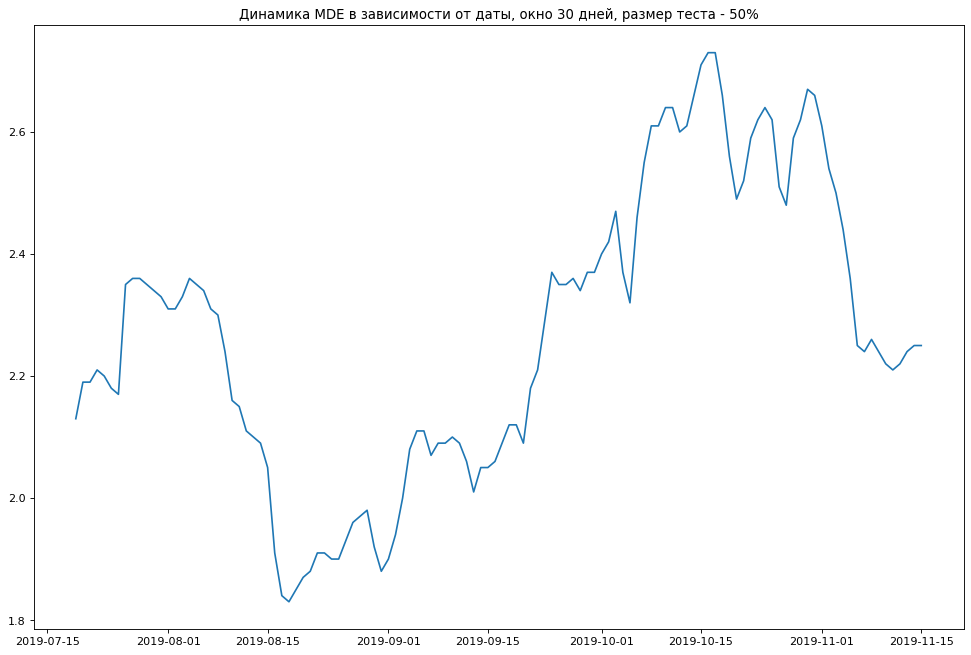

In [503]:
from matplotlib.pyplot import figure

figure(figsize=(15, 10), dpi=80)
plt.plot(MDE_df)
plt.title('Динамика MDE в зависимости от даты, окно 30 дней, размер теста - 50%')
plt.show()

#### Поварьируем количество дней в периоде

In [311]:
time_deltas = np.linspace(10, 80, 8)

array([10., 20., 30., 40., 50., 60., 70., 80.])

**Самый маленький MDE достигается на 30 днях**

In [479]:
time_deltas = np.linspace(10, 80, 8)
for delta in time_deltas:
    print('--------------------------------------------------------------------')
    print('Количество дней - ', delta)
    full_test = cuped_calc(datetime.datetime(2019, 8, 18, 0, 0), df, delta)
    test_sizes = np.array([0.5])

    for j in cntrl_sizes :
        increase, tg_volume = calc_stats_no_days('cuped', full_test,j)
        print('Тестовая группа - ', tg_volume, '(', np.round((1-j)*100), '%)',
              'MDE роста выручки в % - ',increase)

--------------------------------------------------------------------
Количество дней -  10.0
2019-08-18 00:00:00 2019-08-08 00:00:00
2019-08-19 00:00:00 2019-08-29 00:00:00
Тестовая группа -  181701 ( 50.0 %) MDE роста выручки в % -  2.33
--------------------------------------------------------------------
Количество дней -  20.0
2019-08-18 00:00:00 2019-07-29 00:00:00
2019-08-19 00:00:00 2019-09-08 00:00:00
Тестовая группа -  282764 ( 50.0 %) MDE роста выручки в % -  1.95
--------------------------------------------------------------------
Количество дней -  30.0
2019-08-18 00:00:00 2019-07-19 00:00:00
2019-08-19 00:00:00 2019-09-18 00:00:00
Тестовая группа -  374843 ( 50.0 %) MDE роста выручки в % -  1.83
--------------------------------------------------------------------
Количество дней -  40.0
2019-08-18 00:00:00 2019-07-09 00:00:00
2019-08-19 00:00:00 2019-09-28 00:00:00
Тестовая группа -  460817 ( 50.0 %) MDE роста выручки в % -  1.99
--------------------------------------------

### Стратификация

Функция для расчета стратифицированного стандартного отклонения среднего

In [398]:
def sem_strat(data, col_name, metric):
    shares = pd.DataFrame((data.groupby(col_name).count()/data.shape[0])[metric])
    data = data.join(shares, on=col_name, rsuffix='_probability')
    return ((data.groupby([col_name]).var()[metric]*
     data.groupby([col_name]).mean()[metric+'_probability']).sum()/data.count()[0])**0.5

Функция для выбора группы с учетом страт

In [400]:
def choose_date_strats(data, strat, start_date, delta, share): 
    #share - размер контрольной группы
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=tmp.groupby(['user_id', strat]).sum().reset_index()
    #print(tmp.shape[0])
    #check = tmp[(tmp.user_id)%int(1/share)==1].reset_index()
    test, control = train_test_split(tmp, test_size=share)
    return test, control

In [492]:
sem_strat(df.groupby(['user_id','user_segment']).sum(), 'user_segment', 'revenue_amount')

12.285606937427866

Расчет MDE с учетом страт

In [497]:
def calc_stats_strats(metric, dataset, start_date, delta, strat_col, cntrl_size = 0.5):
    np.random.seed(123)
    alpha = 0.01
    power = 0.80
    
    df = dataset.shape[0]-2
    test, control = choose_date_strats(dataset, strat_col, start_date, delta, cntrl_size)
    
    sem_test = sem_strat(test, strat_col, metric)
    sem_control = sem_strat(control, strat_col, metric)
    
    mde = (
        t(df).ppf(1-alpha/2) 
        + 
        t(df).ppf(power) 
    ) * \
     (sem_test ** 2 + sem_control ** 2) ** 0.5
    
    mean = np.round(dataset[metric].mean(),2)
    std = np.round(sem_strat(dataset.groupby(['user_id', strat_col]).sum(), strat_col, metric),2)
    
    return mean, std, np.round(100*((mde+mean)/mean - 1),2), test.shape[0]

Самый маленький MDE достигается на стратификации по региону - что в принципе ожидаемо - при первичном анализе именно на регионе был более менее вразумительный размах по среднему и стандартному отклонения по группам

In [500]:
start_date = datetime.datetime(2019, 8, 18, 0, 0)
days = 30
#test_sizes = np.array([0.5])
cntrl_size = 0.5

strats = ['user_segment', 'category', 'region']

print('Количество дней - ', 30)
for i in strats:
    print('---------------------------------------------')
    print('Группировка по - ', i)
    mean, std, increase, tg_volume = calc_stats_strats('revenue_amount', df, start_date, days, i, cntrl_size)
    print('Среднее - ', mean, 'Strat SEM - ', std)
    print('Тестовая группа - ', tg_volume, '(', np.round((1-j)*100), '%)',
          'MDE роста выручки в % - ',increase)
    
    

Количество дней -  30
---------------------------------------------
Группировка по -  user_segment
Среднее -  400.9 Strat SEM -  12.29
Тестовая группа -  323730 ( 50.0 %) MDE роста выручки в % -  12.78
---------------------------------------------
Группировка по -  category
Среднее -  400.9 Strat SEM -  10.54
Тестовая группа -  354668 ( 50.0 %) MDE роста выручки в % -  11.79
---------------------------------------------
Группировка по -  region
Среднее -  400.9 Strat SEM -  10.35
Тестовая группа -  325156 ( 50.0 %) MDE роста выручки в % -  10.44
